# Wav2Vec2 + MLP Parkinson Detection Model

Wav2Vec2.0 base model is pretrained on massive datasets which helps generalize well.

using:

- Adam optimizer, Separate learning rates for SSL backbone and classifier help preserve pretrained knowledge, with NewBobScheduler schedular.
- freeze early CNN layers to preserve low-level speech features while fine-tuning the Transformer.
- Negative LogLikelihood loss.
- sample_rate is 16KHz for all ssl models



A pretrained Wav2Vec2-based model was fine-tuned for Parkinson’s disease detection using speech data. A model was used to extract embeddings, followed by a simple statistics pooling layer and a lightweight multi-layer perceptron (MLP) classifier. Fine-tuning was conducted over 10 epochs with selective freezing of the feature extractor layers (a frozen convolutional feature extractor and a trainable Transformer encoder). Log-softmax activation and negative log-likelihood loss were used for training. Adaptive learning rates were applied using the NewBob scheduler. This lightweight architecture leverages the generalization capabilities of self-supervised learning (SSL) on speech, requiring minimal task-specific modification while achieving strong performance on our PD detection task.

The model achieved a test accuracy of 97.7%, with class-wise accuracies of 97.9% (PD) and 97.4% (HC). These results demonstrate the effectiveness of self-supervised speech representations for detecting subtle pathological changes in voice.

## imports

In [3]:
from plot_tensorboard import plot_training
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
# import seaborn as sns
import numpy as np
from plot_conf_mat import plot_cm


## Experiment on Full Dataset

### hparams file

In [8]:
%%file hparams_wav2vec.yaml

# Your code here

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Dataset will be downloaded to the `data_original`
data_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/wav2vec2/base/fulldataset/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
sslmodel_hub: facebook/wav2vec2-base
sslmodel_folder: !ref <save_folder>/ssl_checkpoint

# Path where data manifest files will be stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

####################### Training Parameters ####################################
number_of_epochs: 10
batch_size: 4
lr: 0.0001
lr_ssl: 0.00001
sample_rate: 16000

#freeze all ssl
freeze_ssl: False
#set to true to freeze the CONV part of the ssl model
# We see an improvement of 2% with freezing CNNs
freeze_ssl_conv: True

####################### Model Parameters #######################################
encoder_dim: 768

# Number of emotions
out_n_neurons: 2 # (healthy, parkinsons)

dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: True
    num_workers: 2  # 2 on linux but 0 works on windows
    drop_last: False

# ssl encoder
ssl_model: !new:speechbrain.lobes.models.huggingface_transformers.wav2vec2.Wav2Vec2
    source: !ref <sslmodel_hub>
    output_norm: True
    freeze: !ref <freeze_ssl>
    freeze_feature_extractor: !ref <freeze_ssl_conv>
    save_path: !ref <sslmodel_folder>

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

output_mlp: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <encoder_dim>
    n_neurons: !ref <out_n_neurons>
    bias: False

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

modules:
    ssl_model: !ref <ssl_model>
    output_mlp: !ref <output_mlp>

model: !new:torch.nn.ModuleList
    - [!ref <output_mlp>]

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

compute_cost: !name:speechbrain.nnet.losses.nll_loss

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>


Overwriting hparams_wav2vec.yaml


### train file

In [10]:
%%file trainwav2vec.py

# Your code here

#!/usr/bin/env python3
"""Recipe for training an emotion recognition system from speech data only using IEMOCAP.
The system classifies 4 emotions ( anger, happiness, sadness, neutrality) with a SSL model.

To run this recipe, do the following:
> python train.py hparams/train.yaml --data_folder /path/to/IEMOCAP_full_release

Authors
 * Yingzhi WANG 2021
"""

import os
import sys
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
import torch
from sklearn.metrics import confusion_matrix
from confusion_matrix_fig import create_cm_fig
import numpy as np
import torchaudio


class DetectorBrain(sb.Brain):
    def compute_forward(self, batch, stage):
        """Computation pipeline based on a encoder + emotion classifier.
        """
        batch = batch.to(self.device)
        wavs, lens = batch.sig

        outputs = self.modules.ssl_model(wavs, lens)

        # last dim will be used for AdaptativeAVG pool
        outputs = self.hparams.avg_pool(outputs, lens)
        outputs = outputs.view(outputs.shape[0], -1)

        outputs = self.modules.output_mlp(outputs)
        outputs = self.hparams.log_softmax(outputs)
        return outputs

    def compute_objectives(self, predictions, batch, stage):

        """Computes the loss using speaker-id as label.
        """

        
        # loss = self.hparams.compute_cost(predictions, lang_id)
        # if stage != sb.Stage.TRAIN:
        #     self.error_metrics.append(batch.id, predictions, lang_id)
        _, lens = batch.sig
        detection_id, _ = batch.detection_id_encoded

        """to meet the input form of nll loss"""
        detection_id = detection_id.squeeze(1)
        # print('predictions shape= ', predictions.shape)
        # print('detection_id shape= ', detection_id.shape)
        # Compute the cost function
        loss = self.hparams.compute_cost(predictions, detection_id)

        # Append this batch of losses to the loss metric for easy
        self.loss_metric.append(
            batch.id, predictions, detection_id, reduction="batch"
        )

        # Compute classification error at test time
        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(batch.id, predictions, detection_id)

        # Confusion matrices
        if stage != sb.Stage.TRAIN:
            y_true = detection_id.cpu().detach().numpy()#.squeeze(-1)
            y_pred = predictions.cpu().detach().numpy().argmax(-1)#.squeeze(-1)
        if stage == sb.Stage.TEST:
            print('test y_true= ', y_true)
            print('test y_pred= ', y_pred)
            confusion_matix = confusion_matrix(
                y_true,
                y_pred,
                labels=sorted(self.hparams.label_encoder.ind2lab.keys()),
            )
            self.test_confusion_matrix += confusion_matix

        # Compute accuracy using MetricStats
        # print('prediction', predictions)
        # print('detection_id', detection_id)
        self.acc_metric.append(
            batch.id, predict=predictions, target=detection_id, lengths=lens,
        )

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of each epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Set up statistics trackers for this stage
        self.loss_metric = sb.utils.metric_stats.MetricStats(
            metric=sb.nnet.losses.nll_loss
        )

        # Compute accuracy using MetricStats
        # Define function taking (prediction, target, length) for eval
        def accuracy_value(predict, target, lengths):
            """Computes accuracy."""
            # print("Predictions shape:", predict.shape)
            # print("Detection ID shape:", target.shape)
            # print("Lengths shape:", lengths.shape)
            
            predict = predict.unsqueeze(1)
            target = target.unsqueeze(1)
            # print("Predictions after argmax shape:", predict.shape)
            # print("Detection ID target shape:", target.shape)

            nbr_correct, nbr_total = sb.utils.Accuracy.Accuracy(
                predict, target, lengths
            )
            acc = torch.tensor([nbr_correct / nbr_total])
            return acc

        self.acc_metric = sb.utils.metric_stats.MetricStats(
            metric=accuracy_value, n_jobs=1
        )
        if stage == sb.Stage.TEST:
            self.test_confusion_matrix = np.zeros(
                shape=(self.hparams.out_n_neurons, self.hparams.out_n_neurons),
                dtype=int,
            )

        # Set up evaluation-only statistics trackers
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss
            self.train_stats = {
                "loss": self.train_loss,
                "acc": self.acc_metric.summarize("average"),
            }

        # Summarize the statistics from the stage for record-keeping.
        elif stage == sb.Stage.VALID:
            valid_stats = {
                "loss": stage_loss,
                "acc": self.acc_metric.summarize("average"),
                "error_rate": self.error_metrics.summarize("average"),
            }
        # Summarize Test statistics from the stage for record-keeping
        else:
            test_stats = {
                "loss": stage_loss,
                "acc": self.acc_metric.summarize("average"),
                "error_rate": self.error_metrics.summarize("average"),
            }

        # At the end of validation...
        if stage == sb.Stage.VALID:

            old_lr, new_lr = self.hparams.lr_annealing(valid_stats["error_rate"])
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            (
                old_lr_ssl,
                new_lr_ssl,
            ) = self.hparams.lr_annealing_ssl(valid_stats["error_rate"])
            sb.nnet.schedulers.update_learning_rate(
                self.ssl_optimizer, new_lr_ssl
            )

            # Tensorboard logging
            if self.hparams.use_tensorboard:
                self.hparams.tensorboard_train_logger.log_stats(
                    stats_meta={"Epoch": epoch},
                    train_stats=self.train_stats,
                    valid_stats=valid_stats,
                )
                
            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch, "lr": old_lr, "ssl_lr": old_lr_ssl},
                train_stats={"loss": self.train_loss},
                valid_stats=valid_stats,
            )

            # Save the current checkpoint and delete previous checkpoints,
            self.checkpointer.save_and_keep_only(
                meta=valid_stats, min_keys=["error_rate"]
            )  

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            # Per class accuracy from Test confusion matrix
            per_class_acc_arr = np.diag(self.test_confusion_matrix) / np.sum(
                self.test_confusion_matrix, axis=1
            )
            per_class_acc_arr_str = "\n" + "\n".join(
                "{:}: {:.3f}".format(class_id, class_acc)
                for class_id, class_acc in enumerate(per_class_acc_arr)
            )

            self.hparams.train_logger.log_stats(
                {
                    "Epoch loaded": self.hparams.epoch_counter.current,
                    "\n Per Class Accuracy": per_class_acc_arr_str,
                    "\n Confusion Matrix": "\n{:}\n".format(
                        self.test_confusion_matrix
                    ),
                },
                test_stats=test_stats,
            )

    def init_optimizers(self):
        "Initializes the ssl optimizer and model optimizer"
        self.ssl_optimizer = self.hparams.ssl_opt_class(
            self.modules.ssl_model.parameters()
        )
        self.optimizer = self.hparams.opt_class(self.hparams.model.parameters())

        if self.checkpointer is not None:
            self.checkpointer.add_recoverable(
                "ssl_opt", self.ssl_optimizer
            )
            self.checkpointer.add_recoverable("optimizer", self.optimizer)

        self.optimizers_dict = {
            "model_optimizer": self.optimizer,
            "ssl_optimizer": self.ssl_optimizer,
        }


def dataio_prep(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined
    functions. We expect `prepare_mini_librispeech` to have been called before
    this, so that the `train.json`, `valid.json`,  and `valid.json` manifest
    files are available.
    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.
    Returns
    -------
    datasets : dict
        Contains two keys, "train" and "valid" that correspond
        to the appropriate DynamicItemDataset object.
    """

    # Define audio pipeline
    @sb.utils.data_pipeline.takes("path")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the signal, and pass it and its length to the corruption class.
        This is done on the CPU in the `collate_fn`."""
        # sig = sb.dataio.dataio.read_audio(wav)
        sig, fs = torchaudio.load(wav)

        # Resampling
        # print('input signal(s) shape: ', sig.squeeze().shape)
        sig = torchaudio.functional.resample(sig.squeeze(0), fs, hparams["sample_rate"])
        return sig

    # Initialization of the label encoder. The label encoder assignes to each
    # of the observed label a unique index (e.g, 'spk01': 0, 'spk02': 1, ..)
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # Define label pipeline:
    @sb.utils.data_pipeline.takes("detection")
    @sb.utils.data_pipeline.provides("detection", "detection_id_encoded")
    def label_pipeline(detection_id):
        yield detection_id
        detection_id_encoded = label_encoder.encode_label_torch(detection_id)
        yield detection_id_encoded

    # Define datasets. We also connect the dataset with the data processing
    # functions defined above.
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }
    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            replacements={"data_root": hparams["data_folder"]},
            dynamic_items=[audio_pipeline, label_pipeline],
            output_keys=["id", "sig", "detection_id_encoded"],
        )
    # Load or compute the label encoder (with multi-GPU DDP support)
    # Please, take a look into the lab_enc_file to see the label to index
    # mappinng.

    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="detection",
    )

    return datasets, label_encoder


# RECIPE BEGINS!
if __name__ == "__main__":

    # Reading command line arguments.
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training).
    # sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides.
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Tensorboard logging
    if hparams["use_tensorboard"]:
        from speechbrain.utils.train_logger import TensorboardLogger

        hparams["tensorboard_train_logger"] = TensorboardLogger(
            hparams["tensorboard_logs_folder"]
        )

    # Create dataset objects "train", "valid", and "test".
    datasets, label_encoder = dataio_prep(hparams)

    hparams["label_encoder"] = label_encoder
    class_labels = sorted(list(label_encoder.ind2lab.values()))
    # print("Class Labels:", class_labels, list(label_encoder.lab2ind.values()))

    hparams["ssl_model"] = hparams["ssl_model"].to(device=run_opts["device"])
    # freeze the feature extractor part when unfreezing
    if not hparams["freeze_ssl"] and hparams["freeze_ssl_conv"]:
        hparams["ssl_model"].model.feature_extractor._freeze_parameters()

    # Initialize the Brain object to prepare for mask training.
    detection_brain = DetectorBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    detection_brain.fit(
        epoch_counter=detection_brain.hparams.epoch_counter,
        train_set=datasets["train"],
        valid_set=datasets["valid"],
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = detection_brain.evaluate(
        test_set=datasets["test"],
        min_key="error_rate",
        test_loader_kwargs=hparams["dataloader_options"],
    )



Overwriting trainwav2vec.py


In [11]:
!rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/wav2vec2/base/fulldataset/1986

import sys

!{sys.executable} trainwav2vec.py hparams_wav2vec.yaml --data_folder='/home/ulaval.ca/maelr5/scratch/parkinsons' --device='cuda:0' --number_of_epochs=10 --use_tensorboard=True


2025-04-22 02:00:03.043125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-22 02:00:03.068642: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-22 02:00:03.076741: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-22 02:00:03.098787: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-22 02:00:07.271902: W tensorflow/comp

### output (Train log)

```
Epoch: 1, lr: 1.00e-04, ssl_lr: 1.00e-05 - train loss: 4.92e-01 - valid loss: 1.48e-01, valid acc: 9.48e-01, valid error_rate: 5.21e-02
Epoch: 2, lr: 1.00e-04, ssl_lr: 1.00e-05 - train loss: 1.69e-01 - valid loss: 5.81e-02, valid acc: 9.79e-01, valid error_rate: 2.08e-02
Epoch: 3, lr: 1.00e-04, ssl_lr: 1.00e-05 - train loss: 1.01e-01 - valid loss: 2.52e-01, valid acc: 9.27e-01, valid error_rate: 7.29e-02
Epoch: 4, lr: 9.00e-05, ssl_lr: 9.00e-06 - train loss: 5.38e-02 - valid loss: 4.86e-02, valid acc: 9.90e-01, valid error_rate: 1.04e-02
Epoch: 5, lr: 9.00e-05, ssl_lr: 9.00e-06 - train loss: 3.50e-02 - valid loss: 2.58e-01, valid acc: 9.58e-01, valid error_rate: 4.17e-02
Epoch: 6, lr: 8.10e-05, ssl_lr: 8.10e-06 - train loss: 3.21e-02 - valid loss: 3.17e-01, valid acc: 9.58e-01, valid error_rate: 4.17e-02
Epoch: 7, lr: 7.29e-05, ssl_lr: 7.29e-06 - train loss: 3.13e-02 - valid loss: 9.19e-04, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch: 8, lr: 7.29e-05, ssl_lr: 7.29e-06 - train loss: 1.43e-02 - valid loss: 6.94e-02, valid acc: 9.90e-01, valid error_rate: 1.04e-02
Epoch: 9, lr: 6.56e-05, ssl_lr: 6.56e-06 - train loss: 1.51e-02 - valid loss: 7.60e-02, valid acc: 9.90e-01, valid error_rate: 1.04e-02
Epoch: 10, lr: 5.90e-05, ssl_lr: 5.90e-06 - train loss: 9.09e-03 - valid loss: 1.36e-03, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch loaded: 10, 
 Per Class Accuracy: 
0: 0.979
1: 0.974, 
 Confusion Matrix: 
[[47  1]
 [ 1 37]]
 - test loss: 1.60e-01, test acc: 9.77e-01, test error_rate: 2.33e-02
```

'PD' => 0

'HC' => 1

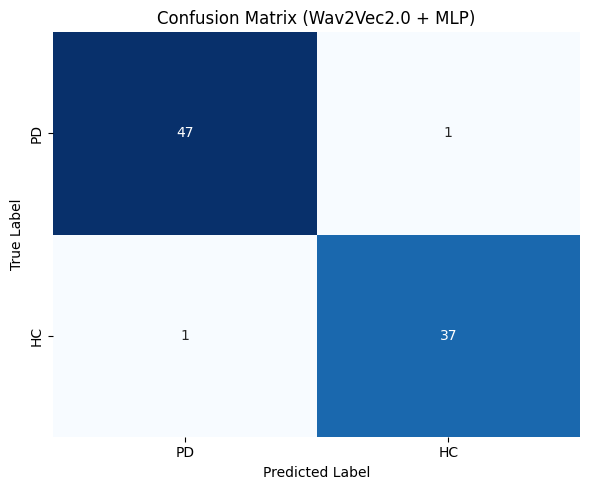

In [4]:

conf_matrix = np.array([[47, 1],   # True PD
                        [1, 37]])  # True HC

plot_cm(conf_matrix, title='Confusion Matrix (Wav2Vec2.0 + MLP)')


### plot the train/valid loss/accuracy during training

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


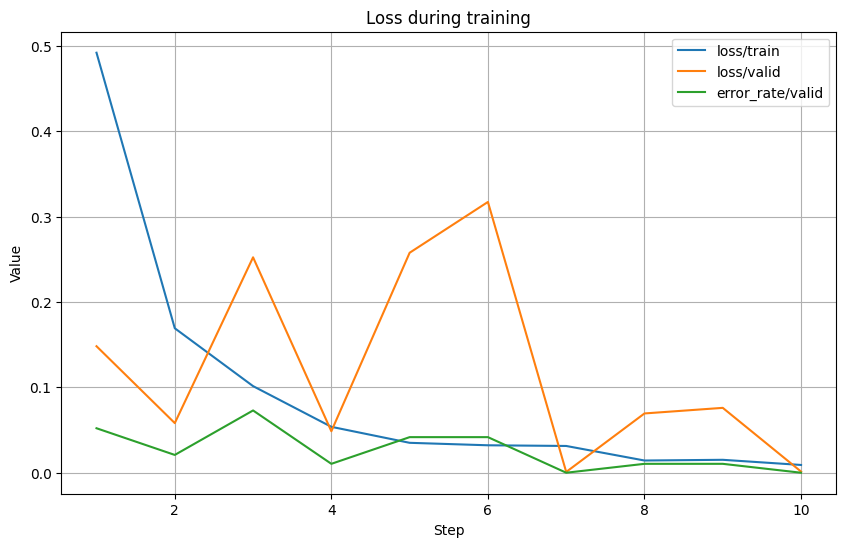

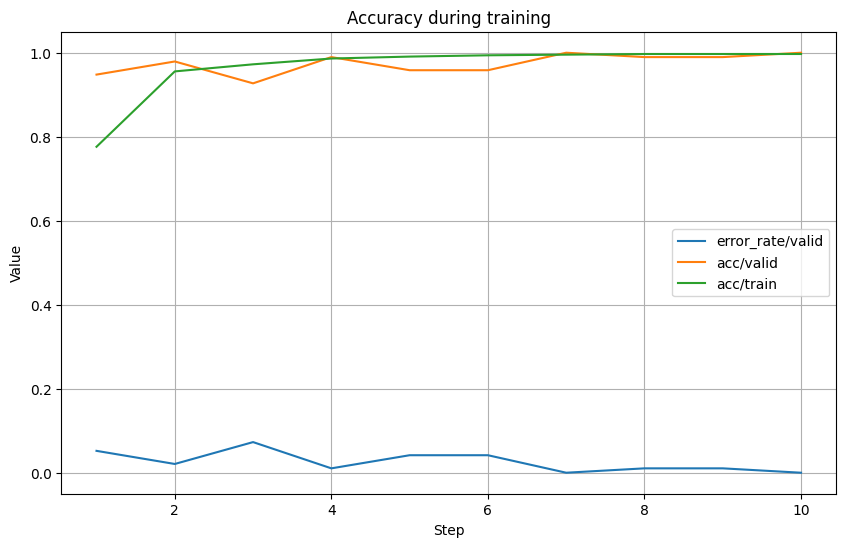

In [13]:
event_file = "/home/ulaval.ca/maelr5/scratch/parkinsons-results/wav2vec2/base/fulldataset/1986/tb_logs/events.out.tfevents.1745301932.ul-val-pr-cpc02.l.ul.ca.2255051.0"
plot_training(event_file)
